Age and Gender Prediction

In [2]:
# import libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
import cv2
from tqdm.notebook import tqdm

# import tensorflow and keras
import tensorflow as tf
import keras
from keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from keras.initializers import random_uniform, glorot_uniform, constant, identity
from keras.layers import Dropout, Input, Add, Dense, Activation, Rescaling,\
    BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, Sequential, load_model
print(dir(keras))



['DTypePolicy', 'FloatDTypePolicy', 'Function', 'Initializer', 'Input', 'InputSpec', 'KerasTensor', 'Layer', 'Loss', 'Metric', 'Model', 'Operation', 'Optimizer', 'Quantizer', 'Regularizer', 'RematScope', 'Sequential', 'StatelessScope', 'SymbolicScope', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_tf_keras', 'activations', 'applications', 'backend', 'callbacks', 'config', 'constraints', 'datasets', 'device', 'distillation', 'distribution', 'dtype_policies', 'export', 'initializers', 'layers', 'legacy', 'losses', 'metrics', 'mixed_precision', 'models', 'name_scope', 'ops', 'optimizers', 'preprocessing', 'quantizers', 'random', 'regularizers', 'remat', 'saving', 'src', 'tree', 'utils', 'version', 'visualization', 'wrappers']


### 1. Load Dataset

In [3]:
from dotenv import load_dotenv

# Import your custom data loading module
# (Make sure data_loader.py is in the same folder as this notebook)
from data_loader import get_unified_dataset


# Load environment variables from .env file
load_dotenv()

# --- 2. Download Datasets (Only if missing) ---
dataset_folder = './datasets'
datasets = [
    'jangedoo/utkface-new',
    'ttungl/adience-benchmark-gender-and-age-classification',
    'aiolapo/fgnet-dataset',
    'moritzm00/biometrically-filtered-famous-figure-dataset'
]

# Authenticate with Kaggle
if not os.getenv("KAGGLE_KEY"):
    print("⚠️ Error: KAGGLE_KEY not found. Please check your .env file.")
else:
    api = KaggleApi()
    api.authenticate()
    
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Simple check: If folder is empty or barely populated, download everything
    # (Adjust this logic if you want to be more specific per dataset)
    if len(os.listdir(dataset_folder)) < 10:  # If less than 10 subfolders, assume datasets are missing
        print("📂 Downloading datasets from Kaggle... this may take a while.")
        for dataset in datasets:
            print(f"   --> Downloading {dataset}...")
            api.dataset_download_files(dataset, path=dataset_folder, unzip=True)
        print("✅ Download complete!")
    else:
        print("✅ Datasets already downloaded.")

# --- 3. Load & Unify Data ---
print("🔄 Processing and loading data...")
df = get_unified_dataset(dataset_folder)

# --- 4. Verify Data ---
print(f"\nTotal Images Loaded: {len(df)}")
print("Source Breakdown:")
print(df['source'].value_counts())

df.to_csv('datasets/df_first.csv', index=False)

# Show sample
df.head()

📂 Downloading datasets from Kaggle... this may take a while.
   --> Downloading jangedoo/utkface-new...
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
   --> Downloading ttungl/adience-benchmark-gender-and-age-classification...
Dataset URL: https://www.kaggle.com/datasets/ttungl/adience-benchmark-gender-and-age-classification
   --> Downloading aiolapo/fgnet-dataset...
Dataset URL: https://www.kaggle.com/datasets/aiolapo/fgnet-dataset
   --> Downloading moritzm00/biometrically-filtered-famous-figure-dataset...
Dataset URL: https://www.kaggle.com/datasets/moritzm00/biometrically-filtered-famous-figure-dataset
✅ Download complete!
🔄 Processing and loading data...
Scanning datasets...
   Searching for Adience files...
   Searching for B3FD images taken after 1980...
   Loaded 33873 B3FD images.
Loaded 74938 images total.
source
b3fd       33873
utkface    23705
adience    16358
fgnet       1002
Name: count, dtype: int64

Total Images Loaded: 74938
Source Breakdown:
sour

,image_path,age,gender,source
0,datasets\UTKFace\100_0_0_20170112213500903.jpg...,100,0,utkface
1,datasets\UTKFace\100_0_0_20170112215240346.jpg...,100,0,utkface
2,datasets\UTKFace\100_1_0_20170110183726390.jpg...,100,1,utkface
3,datasets\UTKFace\100_1_0_20170112213001988.jpg...,100,1,utkface
4,datasets\UTKFace\100_1_0_20170112213303693.jpg...,100,1,utkface


In [4]:
print("Files in ./datasets:", os.listdir('./datasets'))

Files in ./datasets: ['AdienceBenchmarkGenderAndAgeClassification', 'b3fd', 'crop_part1', 'df_first.csv', 'FGNET', 'metadata', 'UTKFace', 'utkface_aligned_cropped']


### 2. Data Exploration

In [3]:
df = pd.read_csv('datasets/df_first.csv')

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 74938 entries, 0 to 74937
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   image_path  74938 non-null  str  
 1   age         74938 non-null  int64
 2   gender      74938 non-null  int64
 3   source      74938 non-null  str  
dtypes: int64(2), str(2)
memory usage: 2.3 MB


In [5]:
# split into 2 dfs for age and gender
df_age = df[['image_path', 'age', 'source']]
df_age = df_age[df_age['age'] > 0]
df_age = df_age[df_age['age'] <= 100]

df_gender = df[['image_path', 'gender', 'source']]
df_gender = df_gender[df_gender['gender'].isin([0, 1])]

*Convert gender to Male and Female labels/categories*

remember to comment out the labelling process so it wont convert again

In [6]:
df['gender'] = df['gender'].astype('category')

df['gender'].value_counts()

gender
-1    34875
 0    20101
 1    19962
Name: count, dtype: int64

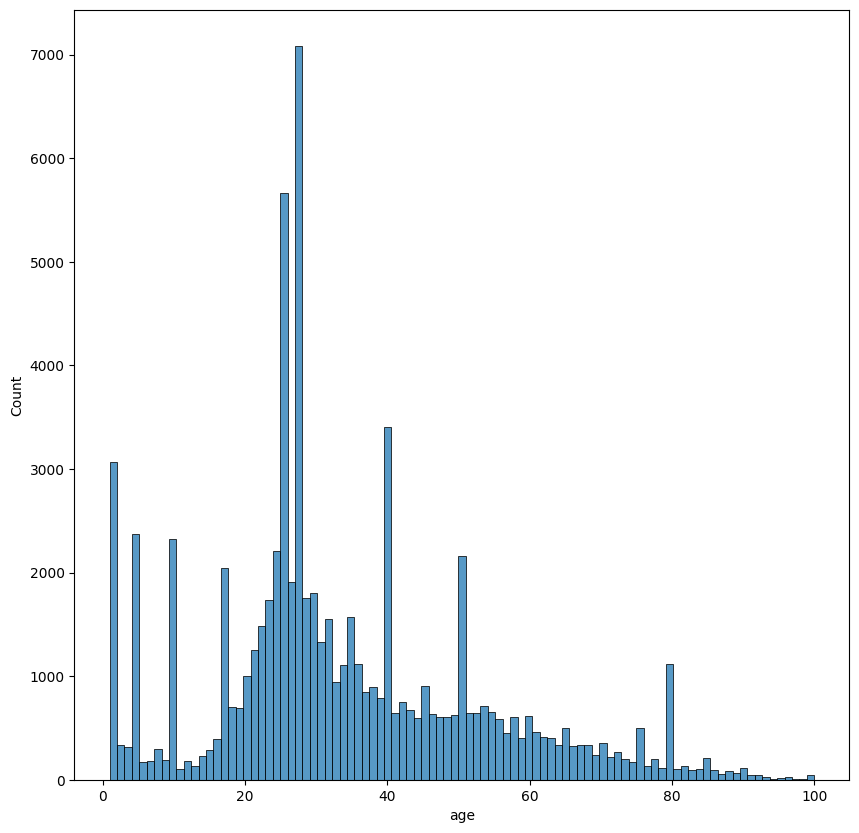

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=df_age, x="age", ax=ax)
plt.show()

Gender Distribution is quite balanced. However, the age distribution is highly imbalanced and heavily skewed towards younger individuals. The histogram reveals a significant peak of data points in the 20-30 year-old range, representing the majority of the dataset. This data imbalance is a critical factor that needs to be addressed before training the CNN model.

**Impact on the CNN Model:**

The model is highly likely to become biased towards the heavily represented age groups (e.g., 20s and 30s). This will lead to excellent prediction accuracy for these ages but poor generalization and significant performance degradation on underrepresented age groups, particularly for older individuals. The model will struggle to accurately predict the age of individuals in these categories, often defaulting to a more common age from the training set.

Hence, it is crucial to implement data balancing techniques such as oversampling the minority classes, undersampling the majority classes, or using weighted loss functions during model training.

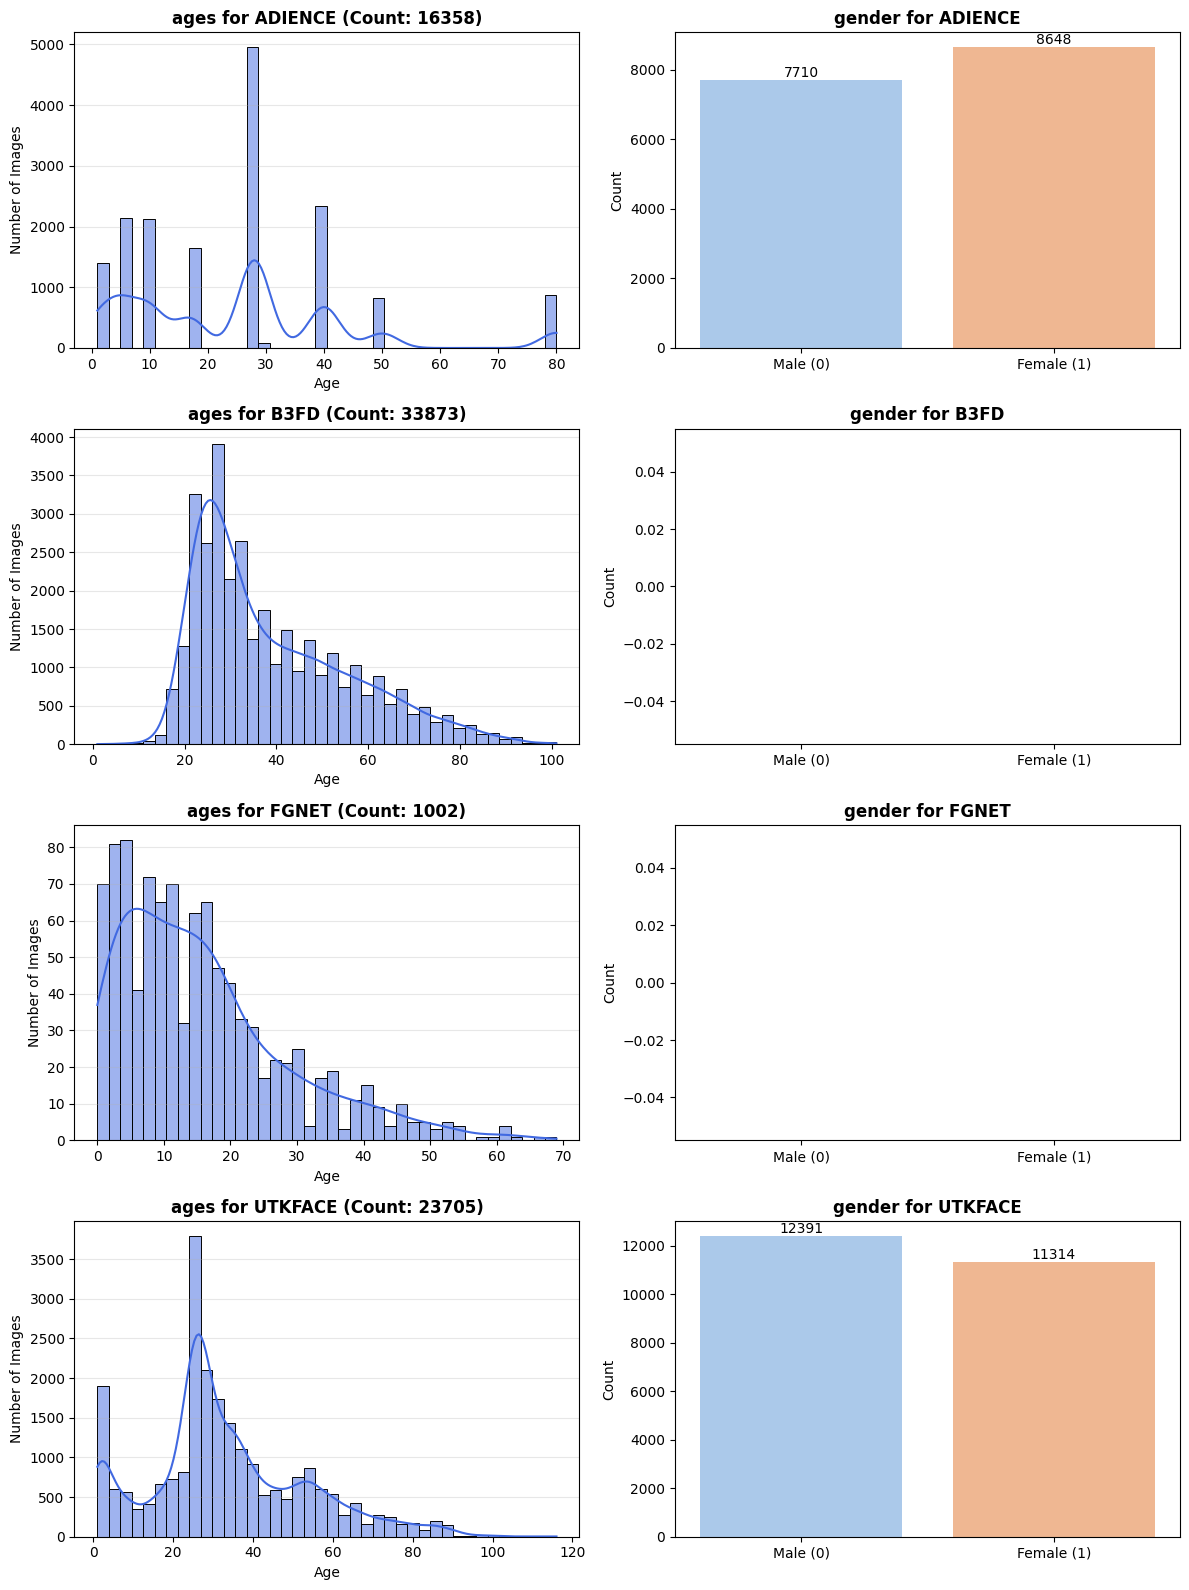

In [8]:
sources = sorted(df['source'].dropna().unique())
fig, axes = plt.subplots(len(sources), 2, figsize=(12, 4 * len(sources)))
axes = np.atleast_2d(axes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for i, source in enumerate(sources):
        subset = df[df['source'] == source]

        sns.histplot(subset['age'], bins=40, kde=True, ax=axes[i, 0], color='royalblue')
        axes[i, 0].set_title(f"ages for {source.upper()} (Count: {len(subset)})", fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel("Age")
        axes[i, 0].set_ylabel("Number of Images")
        axes[i, 0].grid(axis='y', alpha=0.3)

        sns.countplot(x='gender', data=subset, ax=axes[i, 1], palette='pastel', order=[0, 1])
        axes[i, 1].set_title(f"gender for {source.upper()}", fontsize=12, fontweight='bold')
        axes[i, 1].set_xticklabels(['Male (0)', 'Female (1)'])
        axes[i, 1].set_xlabel("")
        axes[i, 1].set_ylabel("Count")
        for container in axes[i, 1].containers:
            axes[i, 1].bar_label(container)

plt.tight_layout()
plt.show()

Measuring 10000 random images...


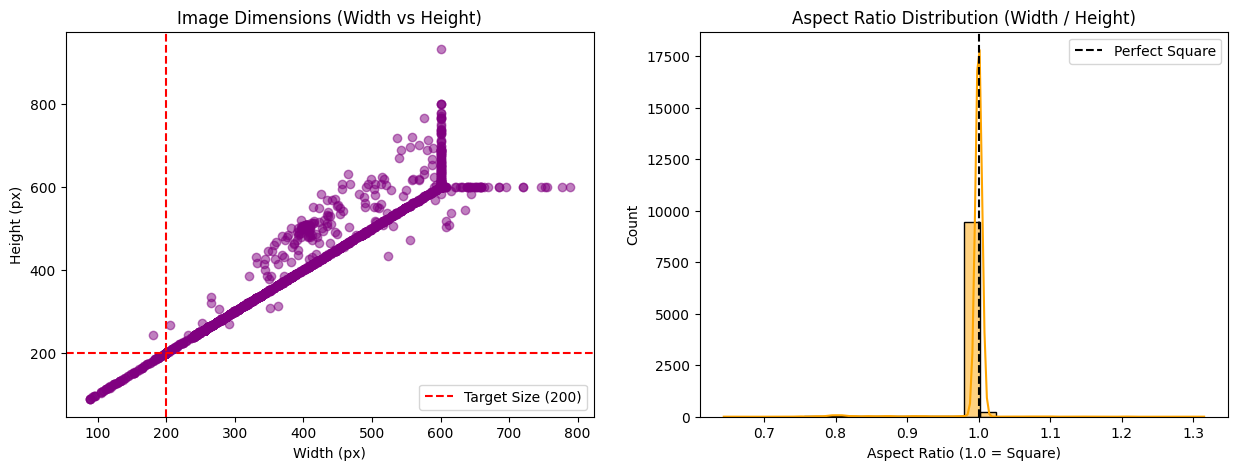

Average Size: 284x286
Smallest Width: 88
Percentage of non-square images: 10.1%


In [9]:
# 1. Sample 10000 images to check (much faster than checking all)
# If you want to check everything, remove .sample(1000)
sample_df = df.sample(n=10000, random_state=42)

widths = []
heights = []
ratios = []

print("Measuring 10000 random images...")

for img_path in sample_df['image_path']:
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            ratios.append(w / h)
    except:
        continue

# --- Visualizing the Results ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Width vs Height
axes[0].scatter(widths, heights, alpha=0.5, color='purple')
axes[0].set_title("Image Dimensions (Width vs Height)")
axes[0].set_xlabel("Width (px)")
axes[0].set_ylabel("Height (px)")
axes[0].axvline(200, color='red', linestyle='--', label='Target Size (200)')
axes[0].axhline(200, color='red', linestyle='--')
axes[0].legend()

# Plot 2: Aspect Ratio Distribution
# Ratio = 1.0 is Square. >1 is Wide, <1 is Tall.
sns.histplot(ratios, bins=30, ax=axes[1], color='orange', kde=True)
axes[1].set_title("Aspect Ratio Distribution (Width / Height)")
axes[1].set_xlabel("Aspect Ratio (1.0 = Square)")
axes[1].axvline(1.0, color='black', linestyle='--', label='Perfect Square')
axes[1].legend()

plt.show()

# Summary Stats
print(f"Average Size: {int(np.mean(widths))}x{int(np.mean(heights))}")
print(f"Smallest Width: {np.min(widths)}")
print(f"Percentage of non-square images: {np.mean(np.array(ratios) != 1.0) * 100:.1f}%")

### 3. Data Preprocessing: Balancing Dataset
   - **Upsample** underrepresented age groups (rare ages with few samples).
   - **Downsample** overrepresented age groups (common ages with too many samples).
   - This helps prevent the model from overfitting to frequent ages and improves performance on rare ones.

In [10]:
age_counts = df_age['age'].value_counts().sort_values()
for i in range(100):
    if i not in age_counts.index:
        print(i)
print(age_counts)

0
age
98       3
97       7
94       9
99      13
95      21
      ... 
5     2376
1     2548
40    3401
26    3637
28    7080
Name: count, Length: 100, dtype: int64


I will need to find images for 94, 97, 98 and upsample 5 more for them. And then downsample all ages to just 2k images, in order to balance the age distribution.

In [11]:
# This step is for creating augmented images for missing ages (94, 97, 98)
# These will be created by the augmentation loop below
# For now, we'll let the augmentation script handle this

# Remove this code block - we'll get these images from the augmentation process
# new_rows = pd.DataFrame({
#     'age': [94, 97, 98],
#     'image_path': [Path('UTKFace_augmented/age_94_lady.jpg'), Path('UTKFace_augmented/age_97_lady.jpg'), Path('UTKFace_augmented/age_97_lady.jpg')],
#     'source': ['augmented', 'augmented', 'augmented']
# })

# df_age = pd.concat([df_age, new_rows], ignore_index=True, sort=False)
# df_age.tail()

In [12]:
# Image Augmentation Strategy
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly translate images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly translate images vertically (fraction of total height)
    brightness_range=[0.8, 1.2],  # Randomly change brightness
    shear_range=0.1,  # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.1, # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'
)

In [13]:
# Create a folder for augmented images
augmented_path = Path("datasets/UTKFace_augmented")
augmented_path.mkdir(exist_ok=True)

In [14]:
# Look for images to augment that actually exist
# First check what data we have
age_counts = df_age['age'].value_counts().sort_values()
print("Ages with fewer than 5 images:")
missing_or_rare_ages = age_counts[age_counts < 10].index.tolist()
print(missing_or_rare_ages)

# Filter to only augment ages that actually have source images
target_ages = [age for age in missing_or_rare_ages if len(df_age[df_age['age'] == age]) > 0]
print(f"\nTarget ages for augmentation (with existing images): {target_ages}")

subset = df_age[df_age['age'].isin(target_ages)]
print(f"Found {len(subset)} images to augment")
print(subset.head())

Ages with fewer than 5 images:
[98, 97, 94]

Target ages for augmentation (with existing images): [98, 97, 94]
Found 19 images to augment
                                              image_path  age source
44516  datasets\b3fd\B3FD\benzionnetanyahu\21901391_1...   97   b3fd
47504  datasets\b3fd\B3FD\countcarljohanbernadotteofw...   94   b3fd
48228  datasets\b3fd\B3FD\danutaszaflarska\28686906_1...   98   b3fd
49107  datasets\b3fd\B3FD\dercygonalves\11933805_1907...   97   b3fd
51428  datasets\b3fd\B3FD\franceslennon\17251719_1912...   94   b3fd


In [15]:
for index, row in subset.iterrows():
    original_img_path = Path(f"{row.image_path}")
    
    # Extract just the filename without extension
    original_filename = original_img_path.stem  # e.g., "image" from "image.jpg"
    
    try:
        # Load the image
        img = Image.open(original_img_path)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)

        i = 0
        for batch in datagen.flow(img_array, batch_size=1):
            augmented_image_array = batch[0]
            augmented_image = array_to_img(augmented_image_array)
            
            # Create filename with _augmented suffix
            augmented_filename = f"{original_filename}_{row['age']}_augmented_{i}.jpg"
            augmented_image_path = augmented_path / augmented_filename
            augmented_image.save(augmented_image_path)
            print(f"Saved augmented image: {augmented_image_path}")
            
            # Add to df_age immediately
            new_row = pd.DataFrame({
                'image_path': [augmented_image_path],
                'age': [row['age']],
                'source': ['augmented']
            })
            df_age = pd.concat([df_age, new_row], ignore_index=True)
            
            i += 1
            if i >= 2:
                break
    except Exception as e:
        print(f"Error processing {original_img_path}: {e}")
        continue

Saved augmented image: datasets\UTKFace_augmented\21901391_1910-03-25_2007_97_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\21901391_1910-03-25_2007_97_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\839957_1916-10-31_2010_94_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\839957_1916-10-31_2010_94_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\28686906_1915-02-06_2013_98_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\28686906_1915-02-06_2013_98_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\11933805_1907-06-23_2004_97_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\11933805_1907-06-23_2004_97_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\17251719_1912-09-12_2006_94_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\17251719_1912-09-12_2006_94_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\14551485_1916-

In [16]:
df_age.tail(10)

,image_path,age,source
74899,datasets\UTKFace_augmented\2659577_1915-06-08_...,94,augmented
74900,datasets\UTKFace_augmented\2659577_1915-06-08_...,94,augmented
74901,datasets\UTKFace_augmented\2058760_1915-12-02_...,97,augmented
74902,datasets\UTKFace_augmented\2058760_1915-12-02_...,97,augmented
74903,datasets\UTKFace_augmented\14045000_1908-06-24...,94,augmented
74904,datasets\UTKFace_augmented\14045000_1908-06-24...,94,augmented
74905,datasets\UTKFace_augmented\12070387_1886-05-20...,94,augmented
74906,datasets\UTKFace_augmented\12070387_1886-05-20...,94,augmented
74907,datasets\UTKFace_augmented\34229463_1912-03-19...,94,augmented
74908,datasets\UTKFace_augmented\34229463_1912-03-19...,94,augmented


#### Downsampling

In [17]:
# --- 1. Settings ---
MAX_IMAGES_PER_AGE = 2000

# --- 2. The Logic ---
processed_chunks = []
unique_ages = df_age['age'].unique()

print(f"🔄 Processing {len(unique_ages)} unique age groups...")

for age in unique_ages:
    # Get all rows for this specific age
    age_group = df_age[df_age['age'] == age]
    
    count = len(age_group)
    
    # Case A: Small group? Keep everything.
    if count <= MAX_IMAGES_PER_AGE:
        processed_chunks.append(age_group)
        
    # Case B: Too big? Downsample while keeping source ratios.
    else:
        # Calculate fraction to keep (e.g., 2000 / 4000 = 0.5)
        frac = MAX_IMAGES_PER_AGE / count
        
        # We group by 'source' within this age and sample strictly.
        # This ensures if we keep 50%, we keep 50% of UTK, 50% of Adience, etc.
        sampled = age_group.groupby('source', group_keys=False).apply(
            lambda x: x.sample(frac=frac, random_state=42)
        )
        processed_chunks.append(sampled)

# --- 3. Combine Back Together ---
# This creates a brand new clean dataframe
df_meow = pd.concat(processed_chunks, ignore_index=True)

print("✅ Downsampling complete!")
print(f"Original size: {len(df_age)}")
print(f"New size:      {len(df_meow)}")

# --- 4. Verify ---
print("\nTop 5 ages by count (Should be ~2000):")
print(df_meow['age'].value_counts().head())

🔄 Processing 100 unique age groups...
✅ Downsampling complete!
Original size: 74909
New size:      65257

Top 5 ages by count (Should be ~2000):
age
5     2001
1     2000
24    2000
25    2000
26    2000
Name: count, dtype: int64


<Axes: xlabel='age', ylabel='Count'>

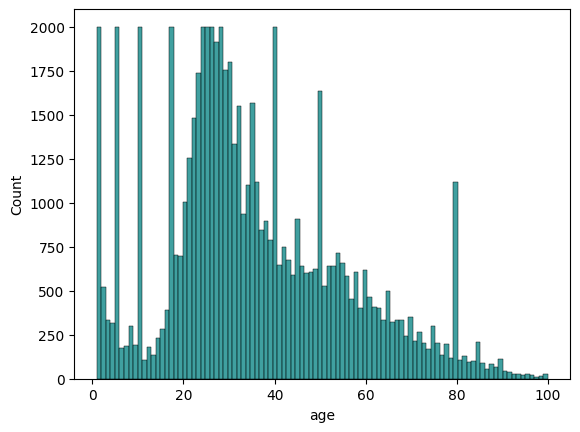

In [18]:
sns.histplot(data = df_meow['age'], bins = 100, color='teal')

##### *Data is definitely more balanced than before.*

In [19]:
# 1. Check current type
is_path_type = df_meow['image_path'].apply(lambda x: isinstance(x, Path)).all()
print(f"Current Status: Are all image_paths 'Path' objects? {is_path_type}")

# 2. FIX IT: If they are strings, convert them back to Path objects
if not is_path_type:
    print("🔄 Converting strings to Path objects...")
    df_meow['image_path'] = df_meow['image_path'].apply(Path)
    
    # Re-check
    is_path_type_now = df_meow['image_path'].apply(lambda x: isinstance(x, Path)).all()
    print(f"✅ Fixed Status: Are all image_paths 'Path' objects? {is_path_type_now}")
else:
    print("✅ No changes needed.")

Current Status: Are all image_paths 'Path' objects? False
🔄 Converting strings to Path objects...
✅ Fixed Status: Are all image_paths 'Path' objects? True


In [20]:
df_meow.info()

<class 'pandas.DataFrame'>
RangeIndex: 65257 entries, 0 to 65256
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  65257 non-null  object
 1   age         65257 non-null  int64 
 2   source      47259 non-null  str   
dtypes: int64(1), object(1), str(1)
memory usage: 1.5+ MB


### 4. Split into response and predictor

##### Data Preparation (df_meow only)
I detect and crop faces with **YOLO-Face**, resize to **224x224**, normalize to **[0,1]**, create `df_meow["age_group"]`, and prepare train/validation data for both outputs.

In [63]:
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

hf_token = os.getenv("HF_TOKEN")

# --- Constants ---
IMAGE_SIZE = (224, 224)
NUM_AGE_GROUPS = 5
BATCH_SIZE = 32
VAL_SPLIT = 0.15
RANDOM_STATE = 42
AUTOTUNE = tf.data.AUTOTUNE

# --- Setup Save Directory ---
# We create a folder to save your cropped faces so you don't have to re-run YOLO later.
save_dir = Path("./processed_faces")
save_dir.mkdir(parents=True, exist_ok=True)

# --- Helper Functions ---

def map_age_to_group(age):
    age = int(age)
    if 0 <= age <= 12:
        return 0  # Child
    if 13 <= age <= 25:
        return 1  # Youth
    if 26 <= age <= 42:
        return 2  # Adult
    if 43 <= age <= 60:
        return 3  # Middle Age
    return 4      # Senior (60+)

# --- Load YOLO Model ---
yolo_face_weights = hf_hub_download(
    repo_id="Bingsu/adetailer",
    filename="face_yolov8n.pt",
    token=hf_token
)
yolo_face_model = YOLO(yolo_face_weights)

def crop_face_with_yolo(image_path: Path, target_size=IMAGE_SIZE, conf_thres: float = 0.3, margin_ratio: float = 0.15):
    # Read image in BGR format (OpenCV default)
    image_bgr = cv2.imread(str(image_path))
    if image_bgr is None:
        return None

    # Run YOLO-Face inference
    result = yolo_face_model.predict(
        source=image_bgr,
        conf=conf_thres,
        verbose=False
    )[0]

    # Handle case where no face is detected
    if result.boxes is None or len(result.boxes) == 0:
        return None

    # Select the largest face (main subject) — ignores smaller background faces
    boxes_xyxy = result.boxes.xyxy.cpu().numpy()
    areas = (boxes_xyxy[:, 2] - boxes_xyxy[:, 0]) * (boxes_xyxy[:, 3] - boxes_xyxy[:, 1])
    x1, y1, x2, y2 = boxes_xyxy[np.argmax(areas)].astype(int)

    # Expand bounding box by margin_ratio on all sides
    # YOLO boxes are tight — 15% margin gives better face context
    h, w = image_bgr.shape[:2]
    bw, bh = (x2 - x1), (y2 - y1)
    mx, my = int(bw * margin_ratio), int(bh * margin_ratio)

    x1 = max(0, x1 - mx)
    y1 = max(0, y1 - my)
    x2 = min(w, x2 + mx)
    y2 = min(h, y2 + my)

    # Crop face region
    face_bgr = image_bgr[y1:y2, x1:x2]
    if face_bgr.size == 0:
        return None

    # Convert BGR -> RGB and resize to target size
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_rgb = cv2.resize(face_rgb, target_size, interpolation=cv2.INTER_AREA)

    # ✅ FIX: Return uint8 [0, 255] — do NOT normalize here.
    # cv2.imwrite() requires uint8 [0,255]. Normalizing to [0,1] floats before
    # saving causes imwrite to clamp all values to 0 (black images).
    # Normalization is handled later by the tf.data pipeline (/ 255.0).
    return face_rgb  # dtype: uint8, range: [0, 255]

print("✅ YOLO face detector loaded. crop_face_with_yolo() ready.")

✅ YOLO face detector loaded. crop_face_with_yolo() ready.


In [64]:
from tqdm import tqdm

# --- Preparation ---
df_meow = df_meow.dropna(subset=["image_path", "age"]).copy()
df_meow["age_group"] = df_meow["age"].apply(map_age_to_group).astype("int32")

processed_metadata = []
skipped_count = 0

print(f"🚀 Starting Processing on {len(df_meow)} images...")

for row in tqdm(df_meow.itertuples(index=False), total=len(df_meow)):
    image_path = Path(str(row.image_path))

    if not image_path.exists():
        skipped_count += 1
        continue

    # Crop face — returns uint8 [0, 255]
    face = crop_face_with_yolo(image_path)
    if face is None:
        skipped_count += 1
        continue

    # Convert RGB -> BGR for OpenCV before saving
    face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

    save_name = f"{int(row.age)}_{image_path.name}"
    save_path = save_dir / save_name
    cv2.imwrite(str(save_path), face_bgr)

    processed_metadata.append({
        "path": str(save_path),
        "age": row.age,
        "age_group": row.age_group
    })

if not processed_metadata:
    raise ValueError("❌ No images processed! Check your image paths and YOLO model.")

# Create clean DataFrame
df_processed = pd.DataFrame(processed_metadata)

# Normalization happens in tf.data pipeline — convert types only here
X = df_processed["path"].values
y_age = df_processed["age"].values.astype("float32")
y_age_group = df_processed["age_group"].values.astype("int32")

df_processed.to_csv("processed_metadata.csv", index=False)

print(f"✅ Processed {len(X)} images. Skipped {skipped_count}.")

# --- Sanity Check: Verify saved images are not black/corrupted ---
print("\n🔍 Verifying saved images...")
sample_paths = df_processed["path"].sample(min(5, len(df_processed)), random_state=42).values
all_ok = True

for p in sample_paths:
    img = cv2.imread(p)
    if img is None:
        print(f"  ❌ Could not read: {p}")
        all_ok = False
        continue
    mean_brightness = img.mean()
    if mean_brightness < 5:
        print(f"  ⚠️  Suspiciously dark image (mean={mean_brightness:.2f}): {p}")
        all_ok = False
    else:
        print(f"  ✅ OK — shape: {img.shape}, mean brightness: {mean_brightness:.1f}")

if all_ok:
    print("\n✅ All sampled images look healthy. Safe to proceed to training.")
else:
    print("\n❌ Some images look corrupted. Do NOT proceed — fix the pipeline first.")

🚀 Starting Processing on 65257 images...


100%|██████████| 65257/65257 [1:03:44<00:00, 17.06it/s]


✅ Processed 58241 images. Skipped 7016.

🔍 Verifying saved images...
  ✅ OK — shape: (224, 224, 3), mean brightness: 134.5
  ✅ OK — shape: (224, 224, 3), mean brightness: 165.9
  ✅ OK — shape: (224, 224, 3), mean brightness: 116.3
  ✅ OK — shape: (224, 224, 3), mean brightness: 73.0
  ✅ OK — shape: (224, 224, 3), mean brightness: 103.3

✅ All sampled images look healthy. Safe to proceed to training.


### Train-test split

In [65]:
# --- 1. Split Data (Train / Val / Test) ---

# I verify stratification requirements quickly to ensure fair age distribution.
stratify_vals = y_age_group if (pd.Series(y_age_group).value_counts().min() >= 2) else None

# First Split: Separate the Test Set (10% of total)
# This data is locked away and only used for the final exam.
X_temp, X_test, y_age_temp, y_age_test, y_group_temp, y_group_test = train_test_split(
    X, y_age, y_age_group,
    test_size=0.10, 
    random_state=RANDOM_STATE,
    stratify=stratify_vals
)

# Recalculate stratify values for the remaining 90%
stratify_vals_temp = y_group_temp if (pd.Series(y_group_temp).value_counts().min() >= 2) else None

# Second Split: Separate Train and Validation
# I use 0.1111 (approx 1/9) because 1/9th of the remaining 90% equals 10% of the total.
# Final Result: Train (80%), Val (10%), Test (10%)
X_train, X_val, y_age_train, y_age_val, y_group_train, y_group_val = train_test_split(
    X_temp, y_age_temp, y_group_temp,
    test_size=0.1111, 
    random_state=RANDOM_STATE,
    stratify=stratify_vals_temp
)

print(f"✅ Data Split Complete:")
print(f"Train: {len(X_train)} samples (80%)")
print(f"Val:   {len(X_val)} samples (10%)")
print(f"Test:  {len(X_test)} samples (10%)")

# --- 2. Dataset Pipeline ---

def load_and_process_image(path, targets):
    """Loads image from disk, decodes, resizes, and normalizes."""
    # I read the raw file from the disk
    img = tf.io.read_file(path)
    # I decode the compressed string into a tensor
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    # I resize it because the model expects a fixed 224x224 input
    img = tf.image.resize(img, IMAGE_SIZE)
    # I normalize pixels from 0-255 to 0-1 for faster convergence
    img = tf.cast(img, tf.float32) / 255.0
    return img, targets

def make_dataset(paths, age_targets, group_targets, training=False):
    # I create the base dataset from paths (Strings) and labels
    ds = tf.data.Dataset.from_tensor_slices((
        paths,
        { "age_group_output": group_targets, "age_output": age_targets }
    ))

    # ⚠️ CRITICAL STEP: Map paths -> Actual Images
    # num_parallel_calls=AUTOTUNE allows my CPU to load multiple images while the GPU trains
    ds = ds.map(load_and_process_image, num_parallel_calls=AUTOTUNE)

    # I only shuffle the training data. 
    # Validation and Test order should stay fixed for consistent evaluation.
    if training:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)

    # I batch the images and prefetch the next batch to avoid bottlenecks
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# --- 3. Create Datasets ---
# I create optimized pipelines for all three sets.
# Note: training=True only for the training set!
train_ds = make_dataset(X_train, y_age_train, y_group_train, training=True)
val_ds   = make_dataset(X_val,   y_age_val,   y_group_val,   training=False)
test_ds  = make_dataset(X_test,  y_age_test,  y_group_test,  training=False)

✅ Data Split Complete:
Train: 46592 samples (80%)
Val:   5824 samples (10%)
Test:  5825 samples (10%)


#### 5. Build & Compile the Model - Architecture: EfficientNetB0 Backbone

Instead of building a custom CNN from scratch, I use **Transfer Learning** with a pre-trained EfficientNetB0 backbone.

##### **EfficientNetB0 (Pre-trained) → GlobalAveragePooling → Dense(Shared) → Split Heads**

1. **EfficientNetB0 Backbone (The "Eye"):**
   - **Why use it?** Unlike my custom CNN which learns from random weights, this model has already been trained on **14 million images** (ImageNet). It already knows how to detect edges, textures, and shapes.
   - **Benefit:** Massive improvement in feature extraction without needing millions of face images.

2. **Freezing the Backbone (Stage 1 Strategy):**
- I set backbone.trainable = False.

- Why? The new layers at the end have random weights. If I trained everything at once, these random errors would propagate back and destroy the pre-trained ImageNet patterns. I keep the backbone "frozen" first to let the new layers learn to work with it.

3. **GlobalAveragePooling2D:**
   - Replaces `Flatten`. Instead of keeping every pixel location, it averages the features map. 
   - **Benefit:** Drastically reduces the number of parameters, preventing overfitting and making the model smaller/faster.

4. **Shared Dense Layer (256 units + ReLU):**
   - Combines the high-level features extracted by EfficientNet into a vector representing the face.
   - **Dropout (Tunable):** Randomly turns off neurons to force the model to learn robust features, preventing it from relying on just one specific visual cue.

5. **Two-Head Output Strategy (Multi-Task Learning):**
   - **Head 1 (Classification):** `Softmax` output for Age Group. Acts as an "anchor" to guide the model towards the general correct range.
   - **Head 2 (Regression):** `Linear` output for Exact Age. Fine-tunes the prediction to get the specific number.
   - **Why?** Learning both tasks simultaneously improves the shared backbone features, making the model smarter than if it learned just one.

6. **Compile the model:**

> _It prepares your model for training by telling it:_
1) _How to learn (optimizer)_   = I use `adam` since it is the best choice for beginners and most practical models
2) _What to measure (metrics)_ 
3) _What to minimize (loss function)_

In [66]:
from tensorflow.keras.applications import EfficientNetB0

def build_tunable_model(hp):
    # I define the hyperparameter search space.
    # 1. Dropout: Controls how much "memory" we delete to prevent overfitting.
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step=0.05)
    
    # 2. Learning Rate: Controls how fast the model learns. 
    # Too fast = unstable; Too slow = takes forever.
    lr = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
    
    # NEW: tune the shared dense layer size
    dense_units = hp.Choice("dense_units", values=[128, 256, 512])

    # --- Input & Backbone ---
    # I define the input shape explicitly.
    inputs = Input(shape=(224, 224, 3), name="image_input")
    
    # EfficientNet expects [0, 255] pixels, but we normalized to [0, 1].
    # I rescale the inputs back to [0, 255] internally.
    x = Rescaling(255.0)(inputs)

    # I load the pre-trained EfficientNetB0.
    # pooling="avg" automatically applies GlobalAveragePooling2D.
    backbone = EfficientNetB0(
        include_top=False, 
        weights="imagenet", 
        input_shape=(224, 224, 3), 
        pooling="avg"
    )
    
    # I freeze the backbone so we don't destroy the pre-trained ImageNet weights 
    # while our new custom heads are initialized randomly.
    backbone.trainable = False
    
    # I extract the features using the frozen backbone.
    features = backbone(x, training=False)

    # --- Shared Layers ---
    # I combine features into a shared dense layer.
    shared = Dense(dense_units, activation="relu", name="shared_dense")(features)
    shared = Dropout(dropout_rate, name="shared_dropout")(shared)

    # --- Output Heads ---
    # Head 1: Age Group (Helper Task)
    age_group_output = Dense(NUM_AGE_GROUPS, activation="softmax", name="age_group_output")(shared)
    
    # Head 2: Exact Age (Main Task)
    age_output = Dense(1, activation="linear", name="age_output")(shared)

    # --- Compile ---
    model = Model(inputs=inputs, outputs=[age_group_output, age_output])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            "age_group_output": "sparse_categorical_crossentropy",
            "age_output": "mean_absolute_error"
        },
        loss_weights={
            "age_group_output": 0.5, # Auxiliary weight (Guide)
            "age_output": 1.0        # Primary weight (Goal)
        },
        metrics={
            "age_group_output": "accuracy", 
            "age_output": "mae"
        }
    )
    return model

print("✅ Model Architecture defined successfully.")

✅ Model Architecture defined successfully.


#### 6. Hyperparameter Search (Tuning)

I use **Keras Tuner (Hyperband)** to automatically find the best configuration.

**What I am searching for:**
1.  **Dropout Rate:** (0.2, 0.3, 0.4, 0.5) - To find the perfect balance for regularization.
2.  **Initial Learning Rate:** (0.001, 0.0005, 0.0001) - To find the best speed to start training.

**Callbacks used during search:**
- **EarlyStopping:** Stops bad trials immediately to save time.
- **ReduceLROnPlateau:** If a trial gets stuck, it lowers the learning rate to try and squeeze out better performance. This ensures every configuration gets a fair chance to reach its best potential.

In [ ]:
import keras_tuner as kt

# I initialize the Hyperband tuner.
tuner = kt.Hyperband(
    build_tunable_model,
    objective=kt.Objective("val_age_output_mae", direction="min"),
    max_epochs=20,
    factor=3,
    hyperband_iterations=2,
    directory="efficientnet_tuning",
    project_name="age_tuning_v2"
)

# --- Define Callbacks ---
# 1. Stop trials that are not improving to save time.
# removed since it can be too aggressive for tuning and may stop promising trials early.
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_age_output_mae', 
    mode="min",
    patience=4,  # I give it a bit more patience since tuning can be noisy
    restore_best_weights=True
)

# 2. Reduce Learning Rate if the model hits a plateau.
# This helps each trial converge better, making the comparison fairer.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_age_output_mae', 
    factor=0.5,    # Reduce LR to 50% of its value to not destroy it completely
    patience=3,    # if just 1 epoch, it's too aggressive for tuning
    mode = 'min',
    min_lr=1e-6
)

print("🚀 Starting Hyperparameter Search...")

# I run the search with both callbacks.
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[stop_early, reduce_lr] 
)

# --- Retrieve Results ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\n🏆 Best Hyperparameters Found:")
print(f"   - Dense Layer Size: {best_hps.get('dense_units')}")  # <--- ADD THIS LINE
print(f"   - Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"   - Initial Learning Rate: {best_hps.get('learning_rate')}")

Trial 28 Complete [04h 11m 52s]
val_age_output_mae: 7.591279029846191

Best val_age_output_mae So Far: 7.502021312713623
Total elapsed time: 1d 14h 08m 50s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
0.3               |0.3               |dropout_rate
0.0001            |0.001             |learning_rate
512               |512               |dense_units
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/20
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 771s 524ms/step - age_group_output_accuracy: 0.4383 - age_group_output_loss: 1.3707 - age_output_loss: 12.2341 - age_output_mae: 12.2341 - loss: 12.9195 - val_age_group_output_accuracy: 0.5587 - val_age_group_output_loss: 0.9870 - val_age_output_loss: 9.8570 - val_age_output_mae: 9.8570 - val_loss: 10.3505 - learning_rate: 1.0000e-04
Epoch 2/20
1456/1456

In [ ]:
# 2. Show the top 10 trials
# This prints a table showing which combinations won and their validation scores.
print("\n📊 TOP 5 TRIALS SUMMARY:")
tuner.results_summary(num_trials=20)


📊 TOP 5 TRIALS SUMMARY:
Results summary
Results in efficientnet_tuning\age_tuning_final
Showing 20 best trials
Objective(name="val_age_output_mae", direction="min")

Trial 0013 summary
Hyperparameters:
dropout_rate: 0.25
learning_rate: 0.0005
dense_units: 512
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0003
Score: 15.808369636535645

Trial 0012 summary
Hyperparameters:
dropout_rate: 0.3
learning_rate: 0.001
dense_units: 256
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0011
Score: 15.81369400024414

Trial 0017 summary
Hyperparameters:
dropout_rate: 0.25
learning_rate: 0.0005
dense_units: 128
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 15.832321166992188

Trial 0011 summary
Hyperparameters:
dropout_rate: 0.3
learning_rate: 0.001
dense_units: 256
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 15.844123840332031

Trial 0015 summary
Hyperpara

In [ ]:
# --- 1. Get the Best Trial ---
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# --- 2. Extract Validation Metrics ---
val_mae = best_trial.score  # This is the objective
val_loss = best_trial.metrics.get_last_value("val_loss")

# Safe retrieval (in case metric names differ)
def safe_get(metric_name):
    try:
        return best_trial.metrics.get_last_value(metric_name)
    except:
        return None

val_acc = safe_get("val_age_group_output_accuracy")
train_loss = safe_get("loss")
train_mae = safe_get("age_output_mae")
train_acc = safe_get("age_group_output_accuracy")

# --- 3. Print Report ---
print(f"🏆 BEST TRIAL ID: {best_trial.trial_id}")
print("-" * 40)

print(f"📉 Validation MAE (Objective): {val_mae:.4f}")
print(f"📉 Validation Loss:            {val_loss:.4f}")

if val_acc is not None:
    print(f"✅ Validation Accuracy:        {val_acc:.4f}")

print("-" * 40)

if train_loss is not None:
    print(f"📉 Training Loss:              {train_loss:.4f}")

if train_mae is not None:
    print(f"📉 Training MAE:               {train_mae:.4f}")

if train_acc is not None:
    print(f"✅ Training Accuracy:          {train_acc:.4f}")

print("-" * 40)
print("Hyperparameters:")
print(best_trial.hyperparameters.values)


🏆 BEST TRIAL ID: 0013
----------------------------------------
📉 Validation MAE (Objective): 15.8084
📉 Validation Loss:            16.5775
✅ Validation Accuracy:        0.3451
----------------------------------------
📉 Training Loss:              16.6474
📉 Training MAE:               15.8716
✅ Training Accuracy:          0.3356
----------------------------------------
Hyperparameters:
{'dropout_rate': 0.25, 'learning_rate': 0.0005, 'dense_units': 512, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0003'}


#### 7. Fine-Tuning (Stage 2: Unfreezing)

Now that the Tuner has found the best architecture (Dropout/Learning Rate) and trained the classification heads, I unfreeze the **EfficientNet backbone**.

**Strategy:**
1.  **Unfreeze Top Layers:** I unfreeze the top ~40 layers of the backbone.
2.  **Low Learning Rate (1e-5):** I use a very small learning rate to gently adapt the pre-trained weights to face features without "forgetting" the general shapes learned from ImageNet.
3.  **Early Stopping:** I set a higher epoch limit (20) but rely on Early Stopping to halt training once the model stops improving.

This step transforms the model from a generic image classifier into a specialized **Face Age Predictor**.

In [58]:
import wandb
from wandb.integration.keras import WandbMetricsLogger  # updated import path

# --- Configuration ---
FINE_TUNE_EPOCHS = 60    # Increased to 50 as a safety buffer (EarlyStopping will cut it short)
FINE_TUNE_LR = 1e-5      # Very low LR to gently adapt pre-trained weights, instead of destroying them
UNFREEZE_TOP_LAYERS = 80 # Only let the top ~3 blocks of EfficientNet learn, about 237 layers

wandb.init(
    project="age-prediction",
    config={
        "fine_tune_lr": FINE_TUNE_LR,
        "unfreeze_layers": UNFREEZE_TOP_LAYERS,
        "backbone": "EfficientNetB0",
        "fine_tune_epochs": FINE_TUNE_EPOCHS,
        "early_stopping_patience": 6,      # log these too — useful for comparing runs
        "reduce_lr_factor": 0.5,
        "reduce_lr_patience": 2
    }
)

# 1. Retrieve the Best Model from the Tuner (It's already trained on Stage 1)
# Note: The tuner returns a COMPILED model, but we must recompile it later anyway.
best_model = tuner.get_best_models(num_models=1)[0]

# 2. Locate the Backbone Layer
# I find the layer named "efficientnetb0" dynamically because its name might vary slightly.
backbone = next(layer for layer in best_model.layers if "efficientnet" in layer.name.lower())

# 3. Unfreeze the Backbone (Master Switch ON)
backbone.trainable = True

# 4. Re-freeze the Bottom Layers
for layer in backbone.layers[:-UNFREEZE_TOP_LAYERS]:
    layer.trainable = False

# 4b. Freeze ALL BatchNorm layers in the backbone regardless of position
# Why: BN layers update running statistics during training. With a small face dataset,
# this causes drift from ImageNet statistics and destabilises fine-tuning.
# Keeping them in inference mode (trainable=False) prevents this.
for layer in backbone.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Verification
trainable_count = sum(1 for layer in backbone.layers if layer.trainable)
total_count = len(backbone.layers)
print(f"🔓 {trainable_count}/{total_count} backbone layers trainable (BN layers frozen)")

# 5. Recompile (CRITICAL STEP)
# You MUST recompile to apply the "trainable=True" changes and set the new Low LR.
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss={
        "age_group_output": "sparse_categorical_crossentropy",
        "age_output": "mean_absolute_error"
    },
    loss_weights={
        "age_group_output": 0.5, # Helper task (Guide)
        "age_output": 1.0        # Main task (Goal)
    },
    metrics={"age_group_output": "accuracy", "age_output": "mae"}
)

# 6. Define Callbacks for Safety
callbacks_fine_tune = [
    # Stop training when val MAE stops improving — patience=5 gives the model room to recover from dips
    tf.keras.callbacks.EarlyStopping(
        monitor="val_age_output_mae",
        mode="min",
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce LR aggressively (to 30%) if stuck — at 1e-5, halving is often not enough of a change
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_age_output_mae",
        mode="min",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    # Save the best model to disk — insurance against kernel crashes
    tf.keras.callbacks.ModelCheckpoint(
        filepath="age_prediction_best_finetune.keras",
        monitor="val_age_output_mae",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    
    WandbMetricsLogger(log_freq="epoch") # Log metrics to Weights & Biases for real-time monitoring
]

print("✅ Fine-tuning setup complete. Ready for Stage 2 training.")

c:\Users\linmy\Age_Gender_predictor_CNN\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🔓 63/239 backbone layers trainable (BN layers frozen)
✅ Fine-tuning setup complete. Ready for Stage 2 training.


🟢 Age Prediction Metrics (regression)
| Metric             | Meaning                                                   |
| ------------------ | --------------------------------------------------------- |
| `age_output_loss`  | Mean Squared Error (how off the predictions are, squared) |
| `age_output_mae`   | Mean Absolute Error (average error in years)              |
| `val_age_output_` | Same as above, but on validation set (unseen data)        |

🟢 Gender Prediction Metrics (classification)
| Metric                       | Meaning                                                      |
| ---------------------------- | ------------------------------------------------------------ |
| `gender_output_accuracy`     | % of genders predicted correctly on training data            |
| `val_gender_output_accuracy` | Same for validation (unseen) data                            |
| `gender_output_loss`         | How wrong the model was on predicting gender (cross-entropy) |


✅ What we can conclude:

1) Model is learning age and gender well
- MAE dropped from 7.8901 → 5.7301 on training
- Validation MAE dropped from 11.1618 → 8.4502

- Gender training accuracy went from 86.46% → 94.58%
- Validation accuracy stayed strong: ~ 86%–88%

2) **No severe overfitting** - Training and validation accuracy/MAE **stay close**


In [59]:
print("🚀 Starting Stage 2 Training (Fine-Tuning)...")
print(f"   LR: {FINE_TUNE_LR} | Max Epochs: {FINE_TUNE_EPOCHS} | Unfrozen Layers: {UNFREEZE_TOP_LAYERS}")

history_fine = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callbacks_fine_tune,
    verbose=1
)

print("\n✅ Fine-Tuning Complete.")
print(f"   Best val MAE achieved: {min(history_fine.history['val_age_output_mae']):.2f} years")

🚀 Starting Stage 2 Training (Fine-Tuning)...
   LR: 1e-05 | Max Epochs: 60 | Unfrozen Layers: 80
Epoch 1/60


1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - age_group_output_accuracy: 0.3460 - age_group_output_loss: 1.5367 - age_output_loss: 15.8712 - age_output_mae: 15.8712 - loss: 16.6395
Epoch 1: val_age_output_mae improved from None to 15.86571, saving model to age_prediction_best_finetune.keras

Epoch 1: finished saving model to age_prediction_best_finetune.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 910s 616ms/step - age_group_output_accuracy: 0.3447 - age_group_output_loss: 1.5381 - age_output_loss: 15.8835 - age_output_mae: 15.8835 - loss: 16.6526 - val_age_group_output_accuracy: 0.3451 - val_age_group_output_loss: 1.5296 - val_age_output_loss: 15.8657 - val_age_output_mae: 15.8657 - val_loss: 16.6305 - learning_rate: 1.0000e-05
Epoch 2/60
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - age_group_output_accuracy: 0.3462 - age_group_output_loss: 1.5360 - age_output_loss: 15.8437 - age_output_mae: 15.8437 - loss: 16.6117
Epoch 2: val_age_output_mae did not improve from 15.86571
1456/1456 ━━━━━━━

KeyboardInterrupt: 

### 8. Save the Final Model

In [ ]:
best_model.save("age_prediction_model_final.keras")
print("✅ Final model saved as age_prediction_model_final.keras")

artifact = wandb.Artifact(name="age-prediction-final", type="model")
artifact.add_file("age_prediction_model_final.keras")
wandb.log_artifact(artifact)

wandb.finish()
print("📊 W&B run closed. View results at https://wandb.ai")

#### 9. Model Evaluation & Performance Visualization

Now that training is complete, I evaluate the final model on the **Test Set**—data it has never seen before. 

I also plot the training curves for the fine-tuning stage to check for:
1. **Convergence:** Did the MAE actually go down?
2. **Overfitting:** Is there a huge gap between Training and Validation performance?

In [ ]:
# --- 1. Evaluate on Test Set ---
# We use the test_ds we created earlier, which is optimized for CPU/GPU efficiency.
print("📊 Evaluating on Test Set...")
results = best_model.evaluate(test_ds, verbose=1)

# Mapping results to names (Model returns: loss, group_loss, age_loss, group_acc, age_mae)
# Note: The order depends on your model.metrics_names
metrics_map = dict(zip(best_model.metrics_names, results))

print(f"\n📈 Final Test Results:")
print(f"   - Age Mean Absolute Error (MAE): {metrics_map['age_output_mae']:.2f} years")
print(f"   - Age Group Accuracy: {metrics_map['age_group_output_accuracy']*100:.2f}%")

141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - age_output_loss: 128.9203 - age_output_mae: 8.4384 - gender_output_accuracy: 0.8896 - gender_output_loss: 0.6463 - loss: 129.5788


[135.16836547851562,
 133.61026000976562,
 0.6954691410064697,
 8.608955383300781,
 0.8860138058662415]

- 98.73,         # Total combined loss
- 97.55,         # Age prediction loss (MSE)
- 0.8378,        # Gender prediction loss (Cross-Entropy)
- 7.55,          # Age prediction MAE (Mean Absolute Error)
- 0.8784         # Gender prediction accuracy

#### 10. Plotting of training history
<br> 

#### Training and Validation Curves

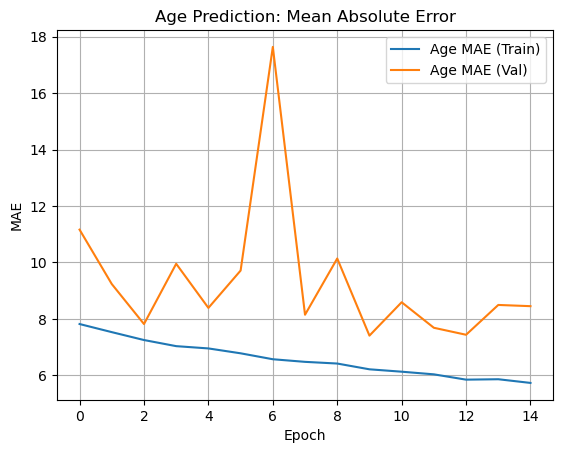

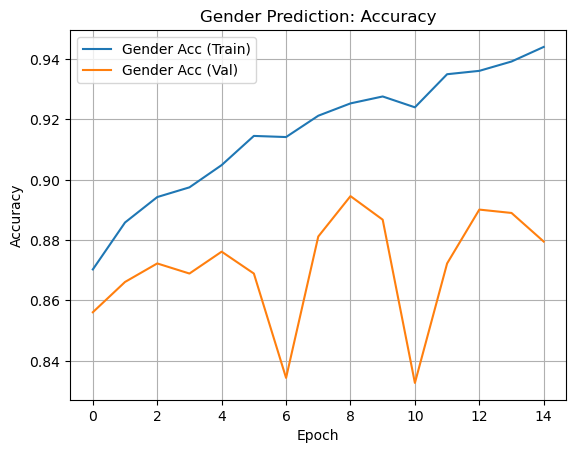

In [ ]:
import matplotlib.pyplot as plt

# We use 'history_fine' from our Stage 2 training
h = history_fine.history

plt.figure(figsize=(14, 5))

# --- Plot 1: Age MAE (Regression) ---
plt.subplot(1, 2, 1)
plt.plot(h['age_output_mae'], label='Train MAE', color='blue', linestyle='--')
plt.plot(h['val_age_output_mae'], label='Val MAE', color='blue', linewidth=2)
plt.title('Age Prediction: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE (Years)')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Age Group Accuracy (Classification) ---
plt.subplot(1, 2, 2)
plt.plot(h['age_group_output_accuracy'], label='Train Acc', color='green', linestyle='--')
plt.plot(h['val_age_group_output_accuracy'], label='Val Acc', color='green', linewidth=2)
plt.title('Age Group: Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 1. Age Prediction (Mean Absolute Error)

🔵 Train MAE steadily decreased from ~7.8 to ~5.7 years, showing that my model is consistently learning from the training data.

🟠 Validation MAE is more unstable, with spikes (up to ~18) around epoch 6, before settling between 7–9 years.

My takeaway:

- The training curve looks healthy, but the validation curve shows signs of overfitting and instability.

- My model may be memorizing training examples too well while struggling to generalize to unseen data.

- To improve, I could try Regularization (e.g., L2 weight decay) and more data augmentation.

#### 2. Gender Prediction (Accuracy)

🔵 Train Accuracy improved smoothly, reaching ~94.5%.

🟠 Validation Accuracy fluctuated between 83–89%, without the same steady upward trend.

My takeaway:

The gap between training and validation accuracy suggests overfitting. My model performs very well on the training set but struggles to maintain stable accuracy on validation.

Possible improvements: Add dropout in convolutional layers (not just at the dense layer). Tune batch size or try early stopping with patience to prevent over-training.

#### ✅ Overall Reflection

Age prediction has promising training results but unstable validation MAE, pointing to generalization issues.

Gender prediction shows high training accuracy but fluctuating validation performance, another sign of overfitting.

I’m happy with the direction my model is going (it clearly learns useful patterns), but I recognize I need to work on improving generalization so that it performs more reliably on new data.

#### 11. Build a new CNN Model - Improve Generatlization

##### To solve my overfitting issues:
1) Use a joint objective in my keras tuning, and change objectives to increase accuracy on validation dataset instead, since training accuracy will usually go up anyways.
2) Add L2 regularization with tuning, to pick optimal regularization as well as Learning Rate
3) Add EarlyStoppiong, ReduceLROnPlateau, and ModelCheckpoint
4) Slightly increase validation split

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

# add l2 regularization to conv layers(2)
def build_regularized_model(hp):
    input_layer = Input(shape=(224, 224, 3))
    
    l2_val = hp.Choice("l2_reg", [1e-4, 5e-4])
    x = Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(l2_val))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(l2_val))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(l2_val))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    age_output = Dense(1, name='age_output')(x)
    gender_output = Dense(2, activation='softmax', name='gender_output')(x)
    
    model = Model(inputs=input_layer, outputs=[age_output, gender_output])
    lr = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            'age_output': 'mse',
            'gender_output': 'categorical_crossentropy'
        },
        metrics={
            'age_output': 'mae',
            'gender_output': 'accuracy'
        }
    )
    return model

# Create a tuner with joint objectives (1)
tuner = kt.RandomSearch(
    build_regularized_model,
    objective= [
        kt.Objective('val_age_output_mae', direction='min'),
        kt.Objective('val_gender_output_accuracy', direction='max')
    ],
    max_trials=10,
    overwrite=True,
    directory='kt_search',
    project_name='age_gender_cnn'
)

tuner.search(X_train, {'age_output': y_age_train, 'gender_output': y_gender_train}, epochs=4, validation_split=0.2)

best_model = tuner.get_best_models(num_models=1)[0]
print('Best learning rate:', tuner.get_best_hyperparameters(1)[0].get('learning_rate'))

Trial 6 Complete [00h 26m 06s]
multi_objective: 7.727886378765106

Best multi_objective So Far: 7.727886378765106
Total elapsed time: 02h 36m 58s
Best learning rate: 0.0005


c:\Users\linmy\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### 12. Building, Comiling & Training 2nd Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Add EarlyStopping (3)
# Stop training if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_age_output_mae', etc.
    patience=3,              # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored quantity
)

# Add ReduceLROnPlateau (3)
# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# Save the best model during training (3)
checkpoint = ModelCheckpoint(
    "best_age_gender.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1 # only log when a model is saved
)

history = best_model.fit(
    X_train, {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_split=0.2,
    epochs=16,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

Epoch 1/16
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - age_output_loss: 119.6715 - age_output_mae: 8.4891 - gender_output_accuracy: 0.8470 - gender_output_loss: 1.0091 - loss: 120.6962
Epoch 1: val_loss improved from inf to 151.49672, saving model to best_age_gender.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 400s 875ms/step - age_output_loss: 119.6702 - age_output_mae: 8.4890 - gender_output_accuracy: 0.8470 - gender_output_loss: 1.0091 - loss: 120.6944 - val_age_output_loss: 149.4209 - val_age_output_mae: 9.1425 - val_gender_output_accuracy: 0.7429 - val_gender_output_loss: 2.0408 - val_loss: 151.4967 - learning_rate: 5.0000e-04
Epoch 2/16
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - age_output_loss: 104.6955 - age_output_mae: 7.9552 - gender_output_accuracy: 0.8618 - gender_output_loss: 0.9750 - loss: 105.6876
Epoch 2: val_loss improved from 151.49672 to 132.21992, saving model to best_age_gender.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 384s 854ms/step - age_output_loss: 104.6964 - age_output_mae

#### 🧠 Training Improvements with Callbacks and Regularization

1. Training Dynamics
- Before, the training loss decreased steadily, but the **validation loss was unstable** and often spiked.  
- With **EarlyStopping**, **ReduceLROnPlateau**, and **ModelCheckpoint**, the training process became **more controlled**:
  - EarlyStopping prevented overtraining once validation stopped improving.  
  - ReduceLROnPlateau automatically reduced the learning rate when a metric has stopped learning. 
  - ModelCheckpoint saved the best-performing model (based on validation loss), so I always kept the strongest version.

2. Age Prediction (MAE)
- Training MAE improved from **~8.5 → 5.8** by the end.  
- Validation MAE dropped and became more stable, hovering around **7.0–7.2** compared to ~9+ before.  
- This shows the model is learning age features better and generalizing more consistently on unseen data.

3. Gender Prediction (Accuracy)
- Training gender accuracy improved to **94%+**, higher than previous runs.  
- Validation gender accuracy consistently reached **~89–90%**, compared to ~86–87% earlier.  
- The validation curve is smoother, showing that regularization + callbacks reduced overfitting.

4. Loss Stability
- Validation loss used to fluctuate heavily (sometimes >150).  
- Now, it **dropped steadily to ~88–90**, with much smaller fluctuations.  
- This demonstrates that learning rate scheduling helped the optimizer settle into better minima.


#### 13. Evaluate on Test Set and Save Model

In [ ]:
best_model.evaluate(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test})

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - age_output_loss: 87.4042 - age_output_mae: 7.1558 - gender_output_accuracy: 0.9001 - gender_output_loss: 0.6186 - loss: 88.0511


[90.9521713256836,
 89.83338928222656,
 0.6337108016014099,
 7.180645942687988,
 0.8998438715934753]

In [ ]:
best_model.save("models/age_gender_model_2.keras")

#### 14. Plot New Training vs Validation Training Curves

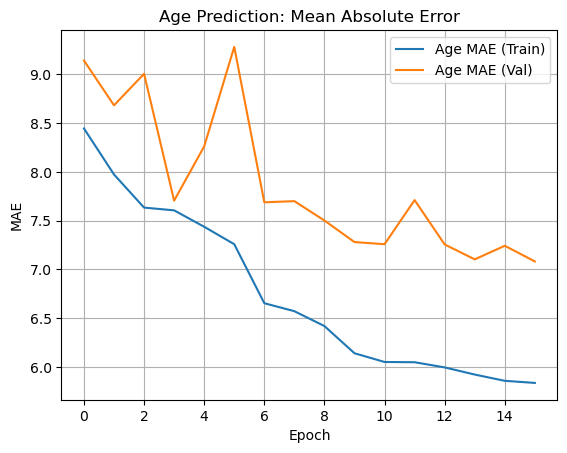

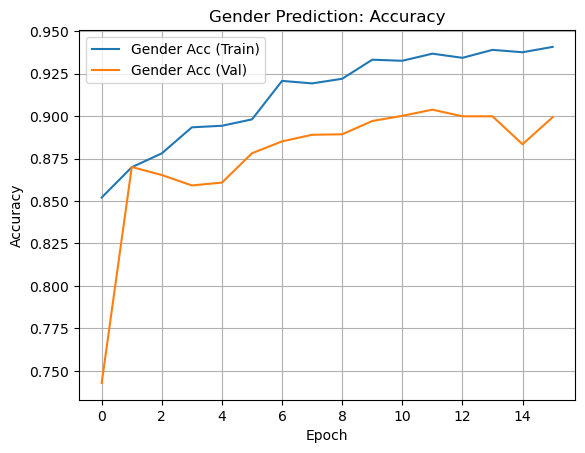

In [ ]:
# Plot Age MAE
plt.plot(history.history['age_output_mae'], label='Age MAE (Train)')
plt.plot(history.history['val_age_output_mae'], label='Age MAE (Val)')
plt.title('Age Prediction: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot Gender Accuracy
plt.plot(history.history['gender_output_accuracy'], label='Gender Acc (Train)')
plt.plot(history.history['val_gender_output_accuracy'], label='Gender Acc (Val)')
plt.title('Gender Prediction: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### 📊 Training Results (After Regularization + Callbacks)

1. Age Prediction (MAE)
- **Training MAE** decreased steadily from ~8.5 → 5.8, showing the model is learning age features effectively.  
- **Validation MAE** fluctuated at the start but stabilized around ~7.0–7.2, much lower than earlier runs (~9+).  

2. Gender Prediction (Accuracy)
- **Training accuracy** increased smoothly from ~85% → 94.5%.  
- **Validation accuracy** climbed from ~74% → ~90%, staying close to the training curve.   

3. Key Takeaways
- Both **age MAE** and **gender accuracy** improved compared to prior models. And the smaller gap between training and validation curves, and smoother validation curves indicates reduced overfitting and better generalization, hence with stabilized validation performance, the model was more robust for deployment.


#### 15. Age Prediction Evaluation - Predicted vs Actual Scatter Plot

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step


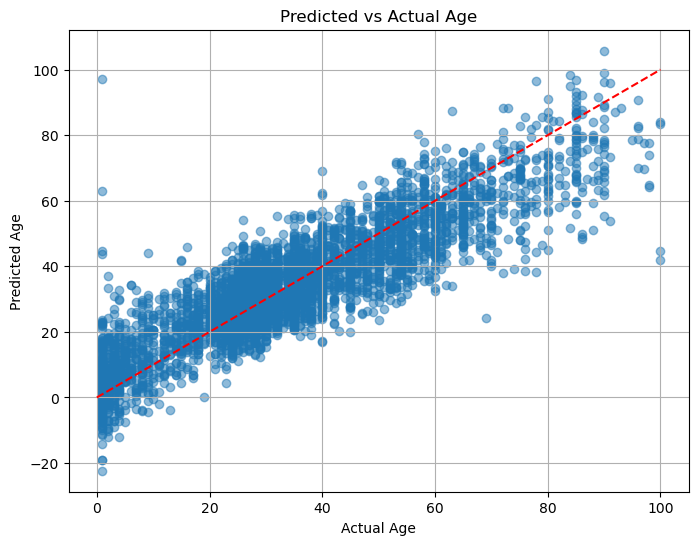

In [ ]:
# Get age predictions (output 0 from the model)
y_pred_age = best_model.predict(X_test)[0].flatten()

# Plot predicted vs actual ages
plt.figure(figsize=(8, 6))
plt.scatter(y_age_test, y_pred_age, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')  # ideal line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs Actual Age')
plt.grid(True)
plt.show()


#### Insights:

- ✅ The model **successfully captures the age distribution trend** with relatively tight clustering along the ideal red line.
- ✅ A small mean absolute error (MAE) and this scatter pattern confirm that the model performs **reasonably well**.
- ⚠️ - There are some outliers:
  - A few predictions below 0 (can be fixed by clamping or using a `ReLU` in the output layer)
  - More scatter and noise at age extremes (e.g. 60+), likely due to fewer samples in those ranges.

> 🎯 Overall, this visual confirms that my CNN is making **informed predictions** and not random guesses.


#### 16. Gender Prediction Evaluation – Classification Report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get gender predictions (output 1 from the model)
y_pred_gender = best_model.predict(X_test)[1]

# Convert one-hot encoded gender back to label
y_pred_gender_labels = np.argmax(y_pred_gender, axis=1)
y_true_gender_labels = np.argmax(y_gender_test, axis=1)

# Generate classification report
print(classification_report(y_true_gender_labels, y_pred_gender_labels, target_names=['Male', 'Female']))

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step
              precision    recall  f1-score   support

        Male       0.89      0.92      0.90      2320
      Female       0.91      0.88      0.89      2163

    accuracy                           0.90      4483
   macro avg       0.90      0.90      0.90      4483
weighted avg       0.90      0.90      0.90      4483



| Class   | Precision | Recall | F1-score | Support | 
|---------|-----------|--------|----------|---------|
| Definition |Out of all the times the model predicted a class, how often was it correct?| Out of all the true samples of a class, how many did the model correctly identify?|  - | - |
| Male    | 0.89      | 0.92   | 0.90     | 2320    |
| Female  | 0.91      | 0.88   | 0.89     | 2163    |

#### Insights:

- ✅ The model achieves a strong **90% overall accuracy** in gender classification.
- ✅ It’s especially strong at identifying **Male** samples (Recall: 92%), meaning it rarely misses when a sample is male.
- ✅ It is more precise when predicting **Female** (Precision: 91%), meaning when it says "Female", it's usually correct.

> 🎯 This confirms that my gender prediction performs well and makes reliable predictions for both classes with balanced precision and recall.
